## Loading Libraries

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
from memory_profiler import memory_usage
import dask.dataframe as dd
import numpy as np

In [2]:
%load_ext rpy2.ipython
%load_ext memory_profiler

## Downloading the Data

In [3]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

In [4]:
# Downloading the file
files_to_dl = ["data.zip"]  
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [5]:
# Extracting the zip file
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

## Combining the CSV Files

In [6]:
%%time
%%memit
files = glob.glob('data/*NSW.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(Model = file.strip('data/').split('_')[0])
                for file in files))
df.to_csv("data/combined_data.csv")

peak memory: 3237.74 MiB, increment: 3160.70 MiB
CPU times: user 5min 57s, sys: 21.9 s, total: 6min 19s
Wall time: 6min 23s


##### Combining CSV Files from Jason's Machine
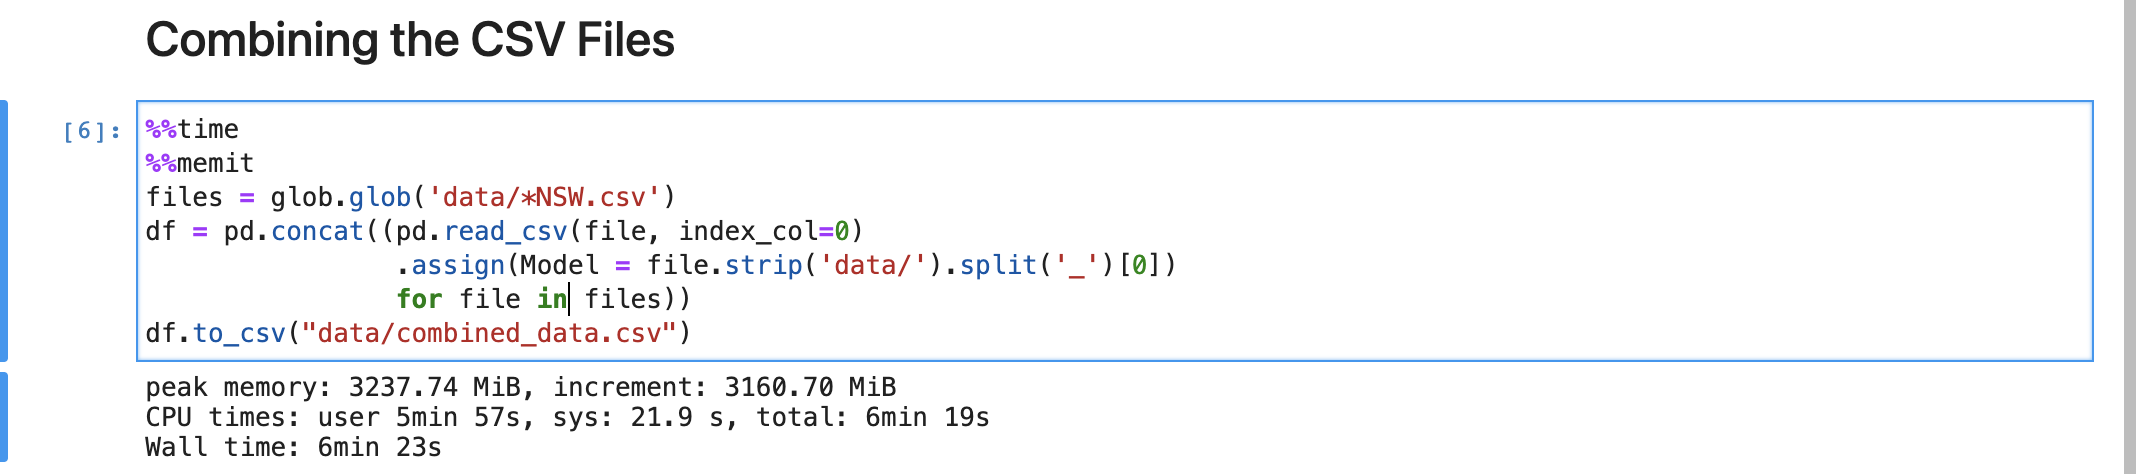

##### Combining CSV Files from Fei's Machine
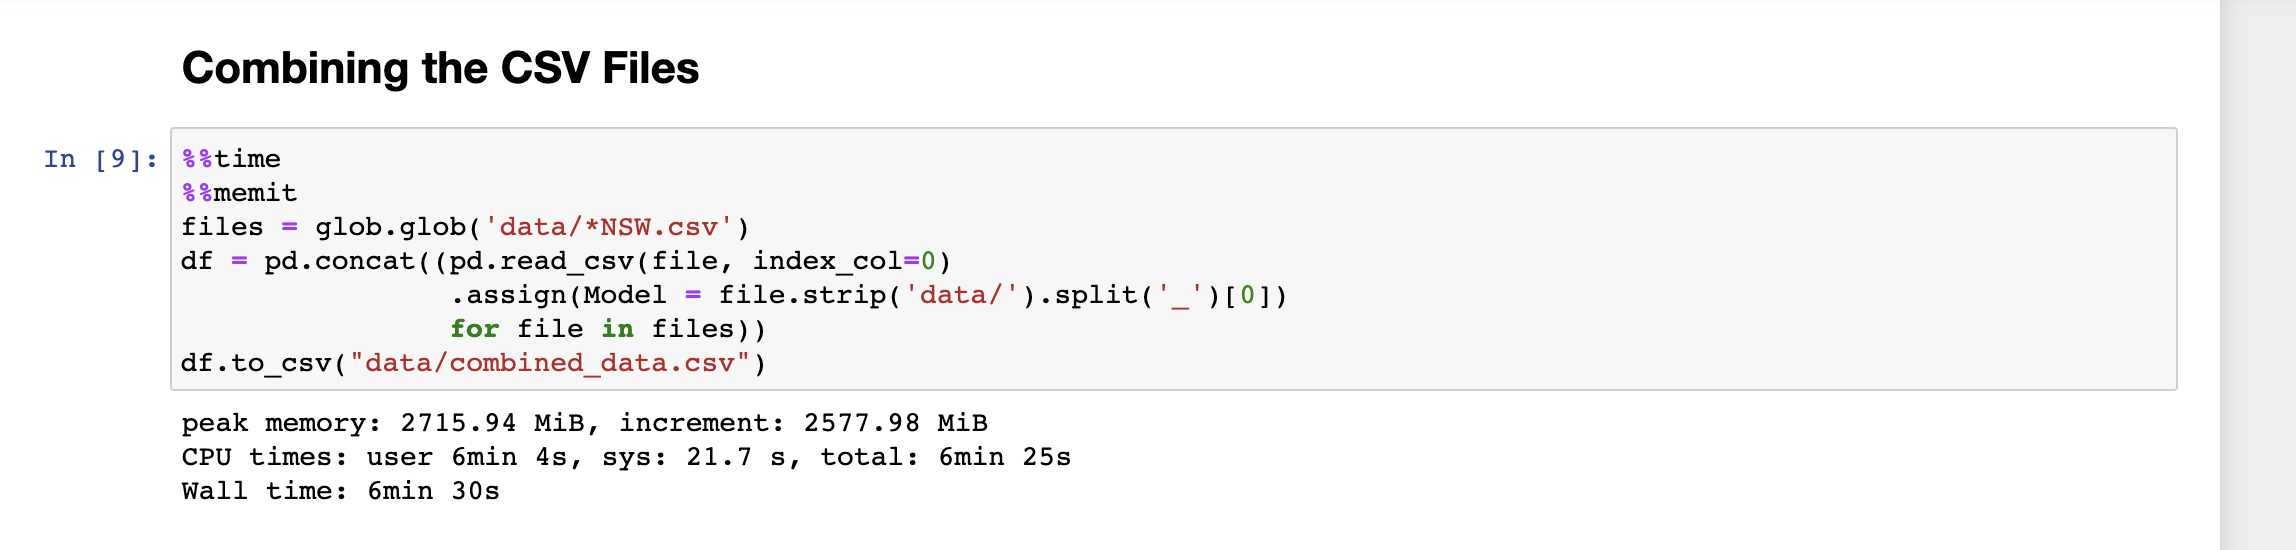

##### Combining CSV Files from Julie's Machine
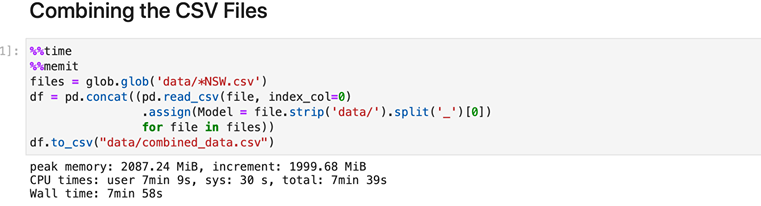

### Discussion of Memory and Time Spent on Combining CSVs

The peak memory used for Jason when combining the csv files is 3237.74Mib. In addition, the overall wall time for combining the csv file for Jason is 6 minutes 23 seconds.

The peak memory used for Fei when combining the csv files is 2715.94 MiB. The overall wall time is roughly the same with Jason's wall time.

The peak memory used for Julie when combining the csv files is 2087.24Mib. The overall wall time is 7min 58 seconds, which is the longest out of everyone.


In [7]:
%%sh
du -sh data/combined_data.csv

5.6G	data/combined_data.csv


### Exploring The Memory Usage by Loading the Data and Performing Simple EDA Via Several Methods

##### Memory Usage when Loading in the Combined CSV File with default Pandas method and computing minimum of rain

In [8]:
%%time
%%memit
combined_df = pd.read_csv('data/combined_data.csv')
print(combined_df['rain (mm/day)'].min())

-3.807372927370557e-12
peak memory: 3612.06 MiB, increment: 1168.91 MiB
CPU times: user 56.9 s, sys: 20.7 s, total: 1min 17s
Wall time: 1min 28s


In [9]:
combined_df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),Model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


##### Loading just the rain Column and computing minimum of rain

In [10]:
%%time
%%memit
single_col = pd.read_csv('data/combined_data.csv', usecols = ['rain (mm/day)'])
print(single_col['rain (mm/day)'].min())

-3.807372927370557e-12
peak memory: 2916.14 MiB, increment: 101.89 MiB
CPU times: user 27.1 s, sys: 3.31 s, total: 30.4 s
Wall time: 31.9 s


##### Loading the data in Chunks and computing minimum of rain

In [11]:
%%time
%%memit
mins = []
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000):
    mins.append(chunk["rain (mm/day)"].min())
print(np.min(mins))

-3.807372927370557e-12
peak memory: 2408.76 MiB, increment: 949.36 MiB
CPU times: user 54.2 s, sys: 7.76 s, total: 1min 1s
Wall time: 1min 3s


##### Loading the data in Dask and computing minimum of rain

In [12]:
%%time
%%memit
dask_df = dd.read_csv('data/combined_data.csv')
print(dask_df["rain (mm/day)"].min().compute())

-3.807372927370557e-12
peak memory: 2018.86 MiB, increment: 1339.17 MiB
CPU times: user 1min 18s, sys: 21.1 s, total: 1min 39s
Wall time: 39.2 s


From the above results, we can see that loading the entire csv file at once using Pandas and performing the EDA consumed the most memory. The second method that consumed the most memory is when loading just the rain column, which is then followed by loading in chunks. Using Dask consumed the least memory out of all 4 methods. On the other hand, in terms of time when performing EDA, loading the entire data costed the longest time, followed by loading by Chunks, then by Dask, and finally by loading just the rain column.

### Transferring Data to R and Performing EDA

In [13]:
%%R
library("arrow")
library("dplyr")

R[write to console]: 
Attaching package: ‘arrow’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [14]:
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow.parquet as pq
import rpy2_arrow.pyarrow_rarrow as pyra
import pyarrow.feather as feather


In [15]:
# Read the combined csv as an arrow table
data = ds.dataset("data/combined_data.csv", format="csv")
table = data.to_table()

##### Writing the table to feather format

In [16]:
%%time
feather.write_feather(table, 'data/combined.feather')

CPU times: user 5.77 s, sys: 14.9 s, total: 20.6 s
Wall time: 11.9 s


In [17]:
%%sh
du -sh data/combined.feather

1.0G	data/combined.feather


##### Writing the table to parquet format

In [18]:
%%time
pq.write_table(table, 'data/combined.parquet')

CPU times: user 10.5 s, sys: 2.56 s, total: 13.1 s
Wall time: 14.3 s


In [19]:
%%sh
du -sh data/combined.parquet

544M	data/combined.parquet


##### Creating arrow format

In [20]:
%%time
arrow_table = pyra.converter.py2rpy(table)

5695
rarrow.ChunkedArray: 0.033772945404052734
5695
rarrow.ChunkedArray: 0.022890090942382812
5695
rarrow.ChunkedArray: 0.040467023849487305
5695
rarrow.ChunkedArray: 0.023092031478881836
5695
rarrow.ChunkedArray: 0.02123284339904785
5695
rarrow.ChunkedArray: 0.02823185920715332
5695
rarrow.ChunkedArray: 0.027025938034057617
CPU times: user 23.7 s, sys: 601 ms, total: 24.3 s
Wall time: 24.7 s


### Simple EDA in R

#### Loading Feather file and calculating the minimum of rain

In [21]:
%%time
%%R
start_time <- Sys.time()
feather_table <- arrow::read_feather("data/combined.feather")
rain = feather_table %>% select(`rain (mm/day)`) 
print(min(rain, na.rm = TRUE))
end_time <- Sys.time()
print(end_time - start_time)

[1] -3.807373e-12
Time difference of 21.38305 secs
CPU times: user 11 s, sys: 22.5 s, total: 33.4 s
Wall time: 21.5 s


#### Loading Parquet file and calculating the minimum of rain

In [22]:
%%time
%%R
start_time <- Sys.time()
feather_table <- arrow::read_parquet("data/combined.parquet")
rain = feather_table %>% select(`rain (mm/day)`) 
print(min(rain, na.rm = TRUE))
end_time <- Sys.time()
print(end_time - start_time)

[1] -3.807373e-12
Time difference of 25.92566 secs
CPU times: user 12.4 s, sys: 21.2 s, total: 33.6 s
Wall time: 26 s


#### Loading Arrow Format and calculating the minimum of rain

In [23]:
%%time
%%R -i arrow_table
start_time <- Sys.time()
rain <- rain %>% collect() %>% select(`rain (mm/day)`)
print(min(rain, na.rm = TRUE))
end_time <- Sys.time()
print(end_time - start_time)

[1] -3.807373e-12
Time difference of 1.826784 secs
CPU times: user 483 ms, sys: 627 ms, total: 1.11 s
Wall time: 1.87 s


#### Discussion on which file format to use

Upon discussion, our group decided to use parquet file as a mean to transfer file from python to R. Even though it takes longer to convert the csv file into a parquet file, the disk space required to store the parquet file is nearly half of that of feather file. In addition, Parquet file is commonly used in big data applications such as Spark and Hadoop and it is also supported by a lot of SQL engines. Hence, the diversity of use as well as the small disk space requirement for Parquet file is what prompted us to use Parquet file as a mean of data format compared to other file formats. 


Source: https://ursalabs.org/blog/2019-10-columnar-perf/